# Abstract
House Price prediction is a very popular dataset for data science competation. In this dataset 79 explanatory variables describing (almost) every aspect of residential homes in Ames and Iowa. This competition challenges compitator to predict the final price of each home.<br /> 
The solution is divided in many parts.The data engineering and preprocessing is inspired from Ref 4,5,6.The Final model is author's own work. Nothing of the model is taken from any book or blog. Although in order to learn tensorflow implementation the book ref:1 helped me a lot. With out the Knowledge taken from ref:1 and 2 this kernal would not exist.<br /> 
The main feature of this kernal is flexiblity. Almost every thing is tunable without coding.<br /> 
The only thing I belive this kernal should have was exhaustive search implementation with I would defenitely do after this one.The plain code with less preprocessing achieved only about 0.215 public score at best.<br /> 
The plain solution with out extra data preprocessing and engineering can be found in the given Github link along with othe rversions of the code. <br />
Github link:https://github.com/IshrakHasin/House-price/tree/master

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


# Understanding the problem label data

Understanding this correlation will help us how we should encode and fillup the respective features.Such as if some feature is very sparse and has weak correlation with sale price we will drop that feature.

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Lets try to understand the correlations with other variables

most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.13

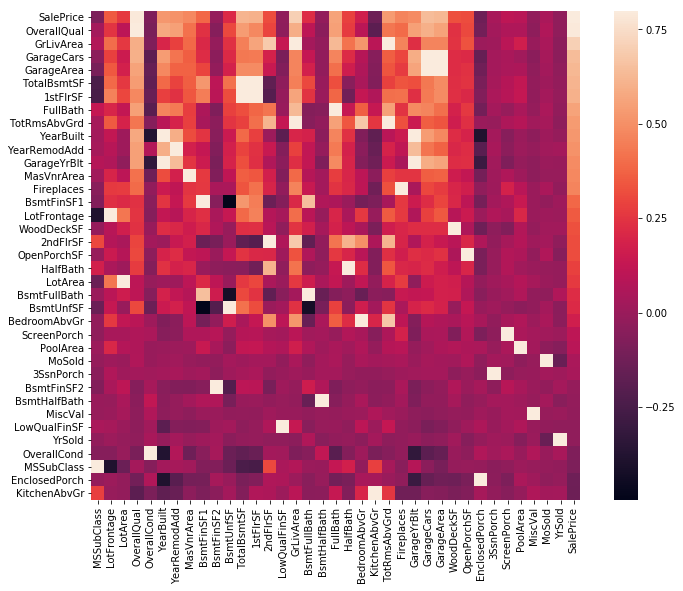

In [5]:
print("most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

# Dataset authur's recommended changes  
The author of the dataset recommends  removing any house more then 4000 sqfeet 

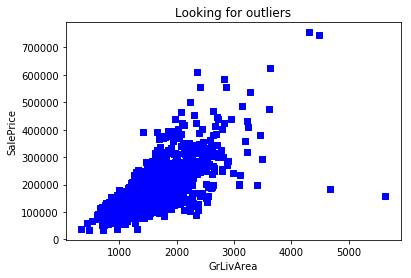

In [6]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

# Data set Concating

In [7]:
train_raw_labels = train['SalePrice'].to_frame().as_matrix()
ntrain = train.shape[0]
ntest = test.shape[0]
train["SalePrice_log"] = np.log1p(train["SalePrice"])
train_labels_with_OT=train["SalePrice_log"]
concated_dataset = pd.concat((train, test)).reset_index(drop=True)
concated_dataset.drop(['SalePrice','SalePrice_log'], axis=1, inplace=True)
nconcated=concated_dataset.shape[0]
print("Concated dataset shape",concated_dataset.shape,"train",train.shape,"test",test.shape)


Concated dataset shape (2915, 79) train (1456, 81) test (1459, 79)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Checking proper spliting

In [8]:
train_post = concated_dataset.iloc[0:1456,:]
test_post = concated_dataset.iloc[1456:2915,:]
print("train shape",train_post.shape)
print("test shape",test_post.shape)

train shape (1456, 79)
test shape (1459, 79)


In [9]:
Test=np.exp(train_labels_with_OT.values)
print(Test)

[208501. 181501. 223501. ... 266501. 142126. 147501.]


# Justifying my reason to take log of saleprice

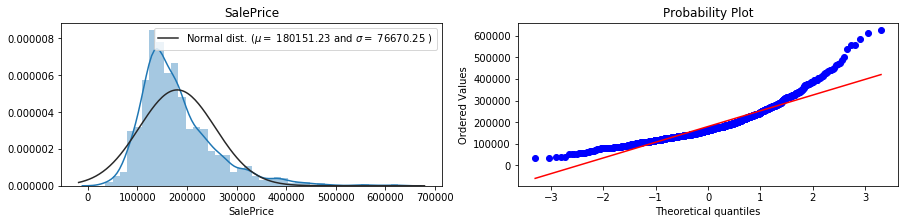

Skewness: 1.565959
Kurtosis: 3.885283


In [10]:
from scipy import stats
from scipy.stats import norm
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('SalePrice')

plt.subplot(122)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

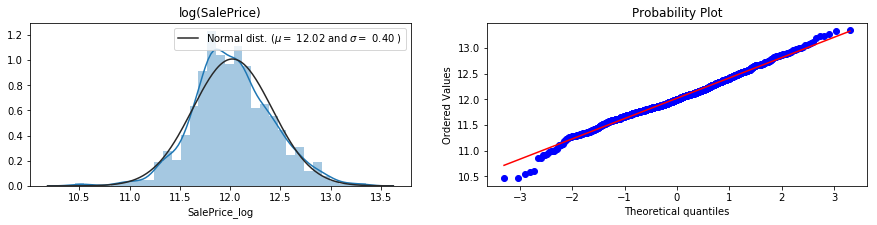

Skewness: 0.065460
Kurtosis: 0.666423


In [11]:
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train_labels_with_OT , fit=norm);

(mu, sigma) = norm.fit(train_labels_with_OT)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('log(SalePrice)')

plt.subplot(122)
res = stats.probplot(train_labels_with_OT, plot=plt)
plt.show()
print("Skewness: %f" % train["SalePrice_log"].skew())
print("Kurtosis: %f" % train["SalePrice_log"].kurt())

# Checking for missing data and handling

In [12]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageQual,5.454545
GarageCond,5.454545
GarageFinish,5.454545
GarageYrBlt,5.454545


In [13]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
concated_dataset.loc[:, "Alley"] = concated_dataset.loc[:, "Alley"].fillna("None")
concated_dataset.loc[:, "BedroomAbvGr"] = concated_dataset.loc[:, "BedroomAbvGr"].fillna(0)
concated_dataset.loc[:, "BsmtQual"] = concated_dataset.loc[:, "BsmtQual"].fillna("No")
concated_dataset.loc[:, "BsmtCond"] = concated_dataset.loc[:, "BsmtCond"].fillna("No")
concated_dataset.loc[:, "BsmtExposure"] = concated_dataset.loc[:, "BsmtExposure"].fillna("No")
concated_dataset.loc[:, "BsmtFinType1"] = concated_dataset.loc[:, "BsmtFinType1"].fillna("No")
concated_dataset.loc[:, "BsmtFinType2"] = concated_dataset.loc[:, "BsmtFinType2"].fillna("No")
concated_dataset.loc[:, "BsmtFullBath"] = concated_dataset.loc[:, "BsmtFullBath"].fillna(0)
concated_dataset.loc[:, "BsmtHalfBath"] = concated_dataset.loc[:, "BsmtHalfBath"].fillna(0)
concated_dataset.loc[:, "BsmtUnfSF"] = concated_dataset.loc[:, "BsmtUnfSF"].fillna(0)
concated_dataset.loc[:, "CentralAir"] = concated_dataset.loc[:, "CentralAir"].fillna("N")
concated_dataset.loc[:, "Condition1"] = concated_dataset.loc[:, "Condition1"].fillna("Norm")
concated_dataset.loc[:, "Condition2"] = concated_dataset.loc[:, "Condition2"].fillna("Norm")
concated_dataset.loc[:, "EnclosedPorch"] = concated_dataset.loc[:, "EnclosedPorch"].fillna(0)
concated_dataset.loc[:, "ExterCond"] = concated_dataset.loc[:, "ExterCond"].fillna("TA")
concated_dataset.loc[:, "ExterQual"] = concated_dataset.loc[:, "ExterQual"].fillna("TA")
concated_dataset.loc[:, "Fence"] = concated_dataset.loc[:, "Fence"].fillna("No")
concated_dataset.loc[:, "FireplaceQu"] = concated_dataset.loc[:, "FireplaceQu"].fillna("No")
concated_dataset.loc[:, "Fireplaces"] = concated_dataset.loc[:, "Fireplaces"].fillna(0)
concated_dataset.loc[:, "Functional"] = concated_dataset.loc[:, "Functional"].fillna("Typ")
concated_dataset.loc[:, "GarageType"] = concated_dataset.loc[:, "GarageType"].fillna("No")
concated_dataset.loc[:, "GarageFinish"] = concated_dataset.loc[:, "GarageFinish"].fillna("No")
concated_dataset.loc[:, "GarageQual"] = concated_dataset.loc[:, "GarageQual"].fillna("No")
concated_dataset.loc[:, "GarageCond"] = concated_dataset.loc[:, "GarageCond"].fillna("No")
concated_dataset.loc[:, "GarageArea"] = concated_dataset.loc[:, "GarageArea"].fillna(0)
concated_dataset.loc[:, "GarageCars"] = concated_dataset.loc[:, "GarageCars"].fillna(0)
concated_dataset.loc[:, "HalfBath"] = concated_dataset.loc[:, "HalfBath"].fillna(0)
concated_dataset.loc[:, "HeatingQC"] = concated_dataset.loc[:, "HeatingQC"].fillna("TA")
concated_dataset.loc[:, "KitchenAbvGr"] = concated_dataset.loc[:, "KitchenAbvGr"].fillna(0)
concated_dataset.loc[:, "KitchenQual"] = concated_dataset.loc[:, "KitchenQual"].fillna("TA")
concated_dataset.loc[:, "LotFrontage"] = concated_dataset.loc[:, "LotFrontage"].fillna(0)
concated_dataset.loc[:, "LotShape"] = concated_dataset.loc[:, "LotShape"].fillna("Reg")
concated_dataset.loc[:, "MasVnrType"] = concated_dataset.loc[:, "MasVnrType"].fillna("None")
concated_dataset.loc[:, "MasVnrArea"] = concated_dataset.loc[:, "MasVnrArea"].fillna(0)
concated_dataset.loc[:, "MiscFeature"] = concated_dataset.loc[:, "MiscFeature"].fillna("No")
concated_dataset.loc[:, "MiscVal"] = concated_dataset.loc[:, "MiscVal"].fillna(0)
concated_dataset.loc[:, "OpenPorchSF"] = concated_dataset.loc[:, "OpenPorchSF"].fillna(0)
concated_dataset.loc[:, "PavedDrive"] = concated_dataset.loc[:, "PavedDrive"].fillna("N")
concated_dataset.loc[:, "PoolQC"] = concated_dataset.loc[:, "PoolQC"].fillna("No")
concated_dataset.loc[:, "PoolArea"] = concated_dataset.loc[:, "PoolArea"].fillna(0)
concated_dataset.loc[:, "SaleCondition"] = concated_dataset.loc[:, "SaleCondition"].fillna("Normal")
concated_dataset.loc[:, "ScreenPorch"] = concated_dataset.loc[:, "ScreenPorch"].fillna(0)
concated_dataset.loc[:, "TotRmsAbvGrd"] = concated_dataset.loc[:, "TotRmsAbvGrd"].fillna(0)
concated_dataset.loc[:, "Utilities"] = concated_dataset.loc[:, "Utilities"].fillna("AllPub")
concated_dataset.loc[:, "WoodDeckSF"] = concated_dataset.loc[:, "WoodDeckSF"].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
concated_dataset['Exterior1st'] = concated_dataset['Exterior1st'].fillna(concated_dataset['Exterior1st'].mode()[0])
concated_dataset['Exterior2nd'] = concated_dataset['Exterior2nd'].fillna(concated_dataset['Exterior2nd'].mode()[0])
concated_dataset['SaleType'] = concated_dataset['SaleType'].fillna(concated_dataset['SaleType'].mode()[0])
concated_dataset['MSZoning'] = concated_dataset['MSZoning'].fillna(concated_dataset['MSZoning'].mode()[0])
concated_dataset['Electrical'] = concated_dataset['Electrical'].fillna(concated_dataset['Electrical'].mode()[0])


Justification for above choices is discussed below.Verify if any data is still missing.

In [14]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


Nothing  has  null 

# Visualize the distribution
before doing any thing else lets visualize the distribution. This looks good!

In [15]:
import math
color = sns.color_palette()
sns.set_style('darkgrid')

In [16]:
def plot_df_distributions(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes != 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*3.5,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            
            if col_idx < len(_columns):
                col = _columns[col_idx]
                sns.distplot(df[col], ax=axes[r_idx][c_idx], fit=norm)
    
    plt.tight_layout()
    plt.show()

In [17]:
def plot_df_countplots(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes == 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            if col_idx < len(_columns):
                col = _columns[col_idx]
                
                sns.countplot(df[col], ax=axes[r_idx][c_idx])
                axes[r_idx][c_idx].set_title(col)
                for item in axes[r_idx][c_idx].get_xticklabels():
                    item.set_rotation(45)
    
    plt.tight_layout()
    plt.show()

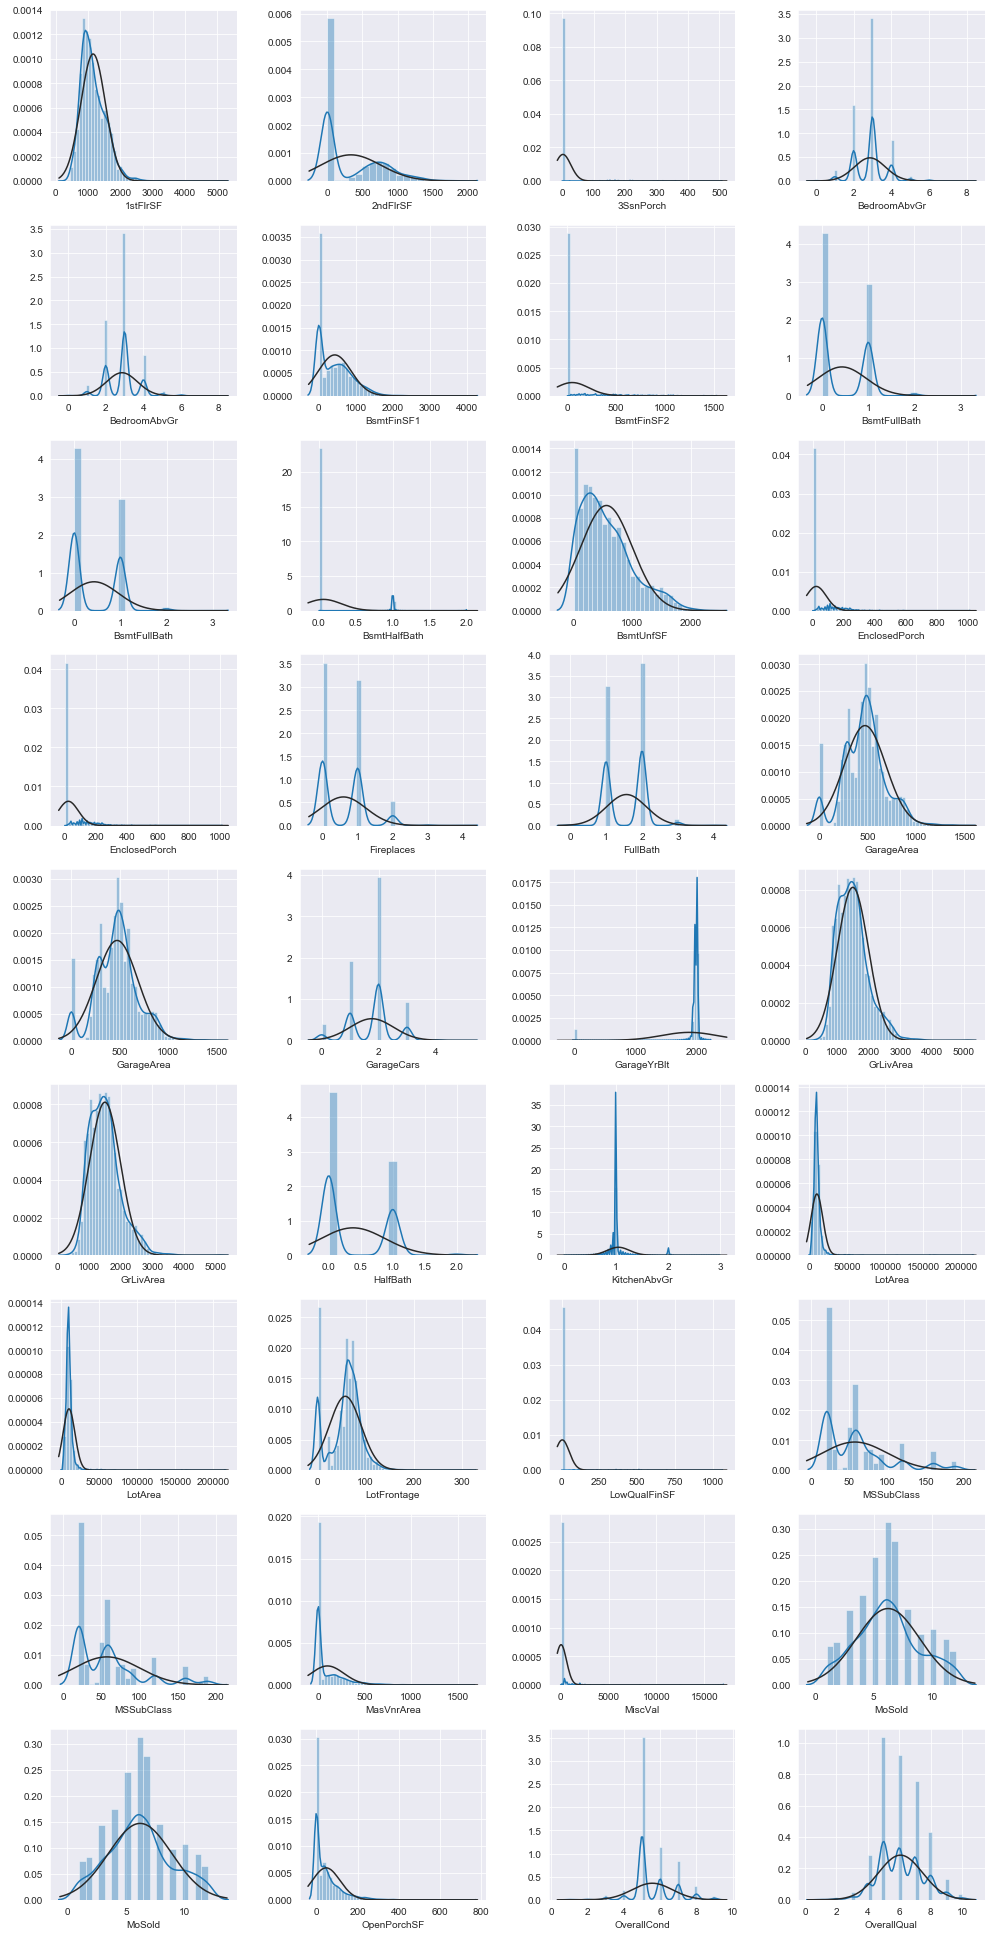

None

In [18]:
display(plot_df_distributions(concated_dataset, num_cols=4))


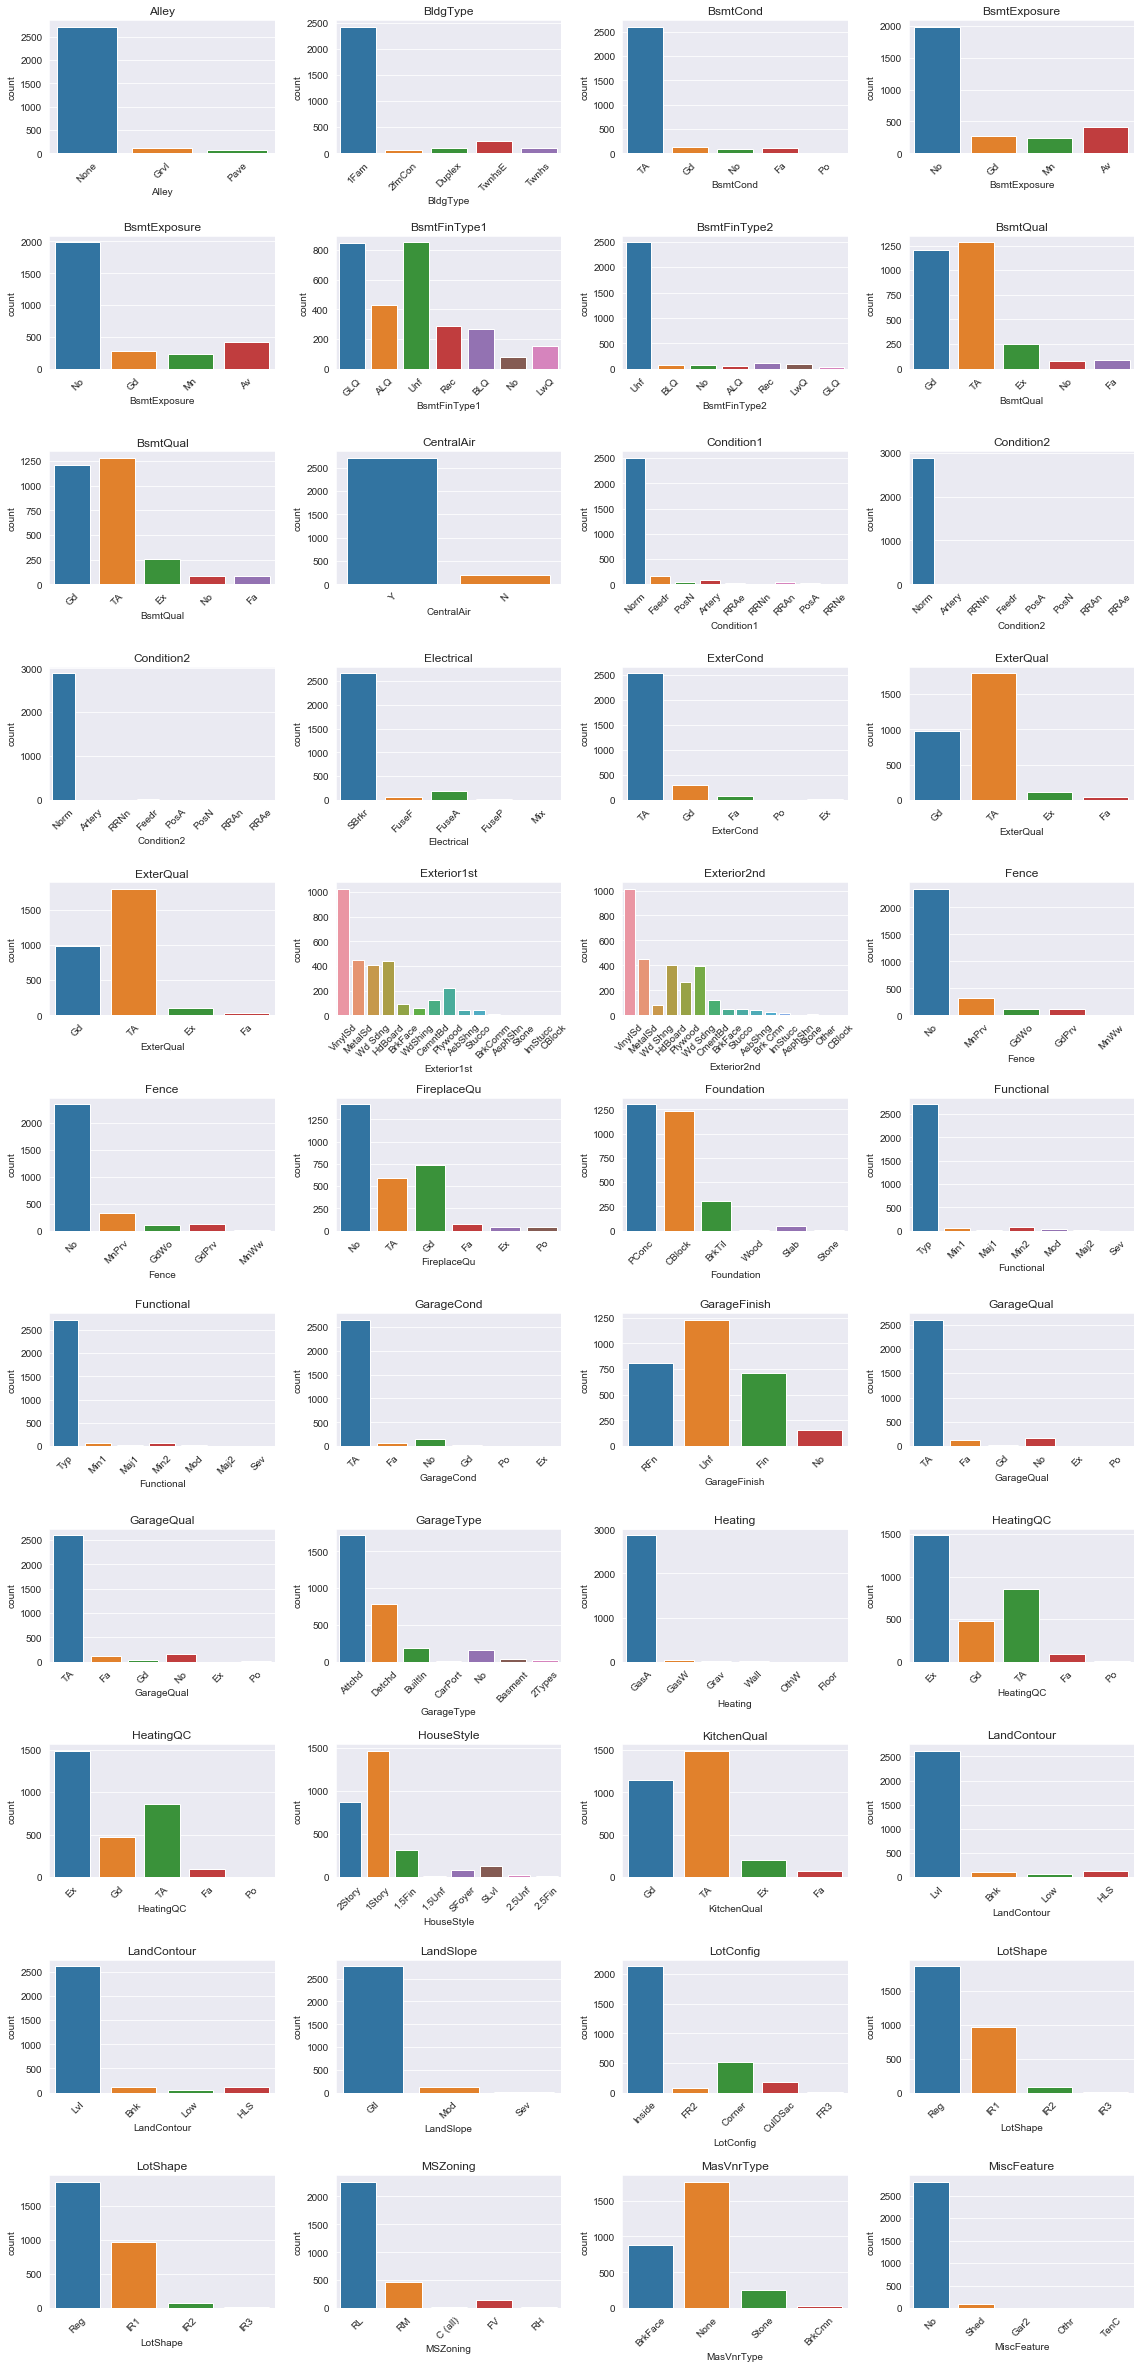

In [19]:
plot_df_countplots(concated_dataset, num_cols=4)


# Black List of feature
Some features are not balanced and badly effect the model. But we can't be sure about that right now.So let's make them black listed.If model is doing well without them we will simly drop them.

In [20]:
black_list=[]
black_list.append('Street')
black_list.append('Condition2')
black_list.append('RoofMatl')
black_list.append('Heating')
black_list.append('MiscVal')
black_list.append('Utilities')


# Add Features 
Lets add some new features. Those features are made out of prior experice on sloving that same problem.We have seen that simple applying One hot encoding and label encoding made our models performace stuck (public score=.24). So this time we will add some new features.


# Feature Encoding
For training through neural network our features must the in some numerical value. Since gradiantent decent algorithm (such as back propagation ) uses derivative to get optimised value of wights.Lets catagorize the the catgorical feature! 

In [21]:
# Some numerical features are actually really categories
concated_dataset = concated_dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [22]:
# Encode some categorical features as ordered numbers when there is information in the order
concated_dataset = concated_dataset.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [23]:
concated_dataset = concated_dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# 1.Feature  Engineering
Adding new featues showed some great improvement in accuracy

# 1.0 Simplified Feature
We will add some simplified version of existing feature

# 1.1 Combine Existing Feature
We will create and append some new feature. Those are creating from the existaing feature.

# 1.2 Double simpling
Now we will find the features which has most impact on target

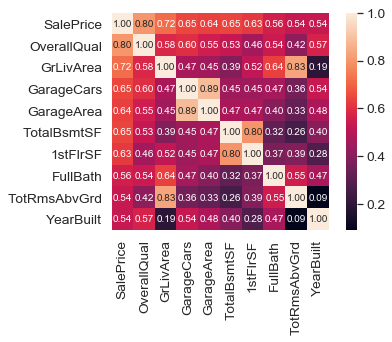

In [24]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Feature type Analysis

In [25]:
categorical_features = concated_dataset.select_dtypes(include = ["object"]).columns
numerical_features = concated_dataset.select_dtypes(exclude = ["object"]).columns
print(categorical_features)
print(numerical_features)
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
Numerical_feature=numerical_features.values
print(Numerical_feature)

Index(['Alley', 'BldgType', 'BsmtCond', 'CentralAir', 'Condition1',
       'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence',
       'Foundation', 'GarageFinish', 'GarageType', 'Heating', 'HouseStyle',
       'LandContour', 'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType',
       'MiscFeature', 'MoSold', 'Neighborhood', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'EnclosedPorch', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Fireplaces',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageQual', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'HeatingQC',
       'KitchenAbvGr', 'KitchenQual', 'LandSlope', 'LotArea', 'LotFrontage',
       'LotShape', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'Op

# Label encoding

In [26]:
concated_dataset_num = concated_dataset[numerical_features]
concated_dataset_cat = concated_dataset[categorical_features]


We created some new features. Those might be sparse. So filling those up. 

In [27]:
print("NAs for numerical features in train : " + str(concated_dataset_num.isnull().values.sum()))
concated_dataset_num = concated_dataset_num.fillna(concated_dataset_num.median())
print("Remaining NAs for numerical features in train : " + str(concated_dataset_num.isnull().values.sum()))

NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


In [28]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


In [29]:
from sklearn.preprocessing import LabelEncoder
for c in categorical_features:
    lbl = LabelEncoder() 
    lbl.fit(list(concated_dataset[c].values)) 
    concated_dataset[c] = lbl.transform(list(concated_dataset[c].values))


# Explaination for above choices
choices for fiiling missing data and replacement. This part is for illustration and explaination.So code are commented as they are coded previously .

From the list we can begin working with data filling.First let check what is PoolQC and why this is empthy.This have four values Ex=Excellent,Gd=Good,TA=typical,Fa=Fair,NA=no pool.So may be missing data should be NA.Lets also help our model by just replacing with neumerical values I will give Ex=4 and No Pool=0. Since the saleprice should be higher if the PoolQC is more.

Now this looks good. Now we can investigate next feature. Which MiscFeature is 96% missing data.This has Elev {Elevator}, Gar2 {2nd Garage} ,Othr {Other},Shed {Shed (over 100 SF}TenC {Tennis Court},NA   {None} values.But we can but keep NA lets replace. We also need to make it catagorical at some point.This feature is also black listed.

Now lets fill up Alley.This can be of 3 types Gravel, paved and No Alley which means NA will have different meaning.We will one hot encode that.

Lets encode time like feature.Well we should one hot encode those but lets's see how it helps if we let it behave like neumerical feature 

Now lets find out how to encode fireplace. From the descreption Ex Excellent - Exceptional Masonry Fireplace Gd Good - Masonry Fireplace in main level TA Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement Fa Fair - Prefabricated Fireplace in basement Po Poor - Ben Franklin Stove NA No Fireplace So we can replace Ex with 5 and NA with 0.

LotFrontage: Linear feet of street connected to property.NA probably means not given. LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

GarageType, GarageFinish, GarageQual, GarageCond is NA if no Garage is there. NA should be replaced with None.I will fill up maually.

Lets's keep a list of things we can't decide where it is ranked or not.


In [33]:
Undecided_ranked=[]
Undecided_unranked=[]
Undecided_unranked.append("Functional")
Undecided_unranked.append("Alley")
Undecided_unranked.append("BsmtFin1")
Undecided_unranked.append("Bsmtfin2")
Undecided_ranked.append("Fence")

In [34]:
Undecided_ranked.append("PavedDrive")

LotShape: General shape of property
       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
Does general shape better then Irregular.Not always may be fency Irregular shape is more costly.For now manulay encode that but adding to undeceded list for future experiment.

In [35]:
Undecided_ranked.append("LandSlope")
Undecided_ranked.append("LotShape")

Adding simplified version of existing feature.

Let's take unorder catagorical data to str. So that we can use pd dummy to one hot encode. 

# Searching skewness
Neural network works best when it distribution is taken from normal distribution. Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.

In [36]:
from scipy.stats import skew
feature_skewness = concated_dataset[Numerical_feature].apply(lambda x: skew(x.dropna()))
feature_skewness = feature_skewness.sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : feature_skewness})
skewness.head(10)

,Skew
MiscVal,21.932147
PoolQC,21.906328
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


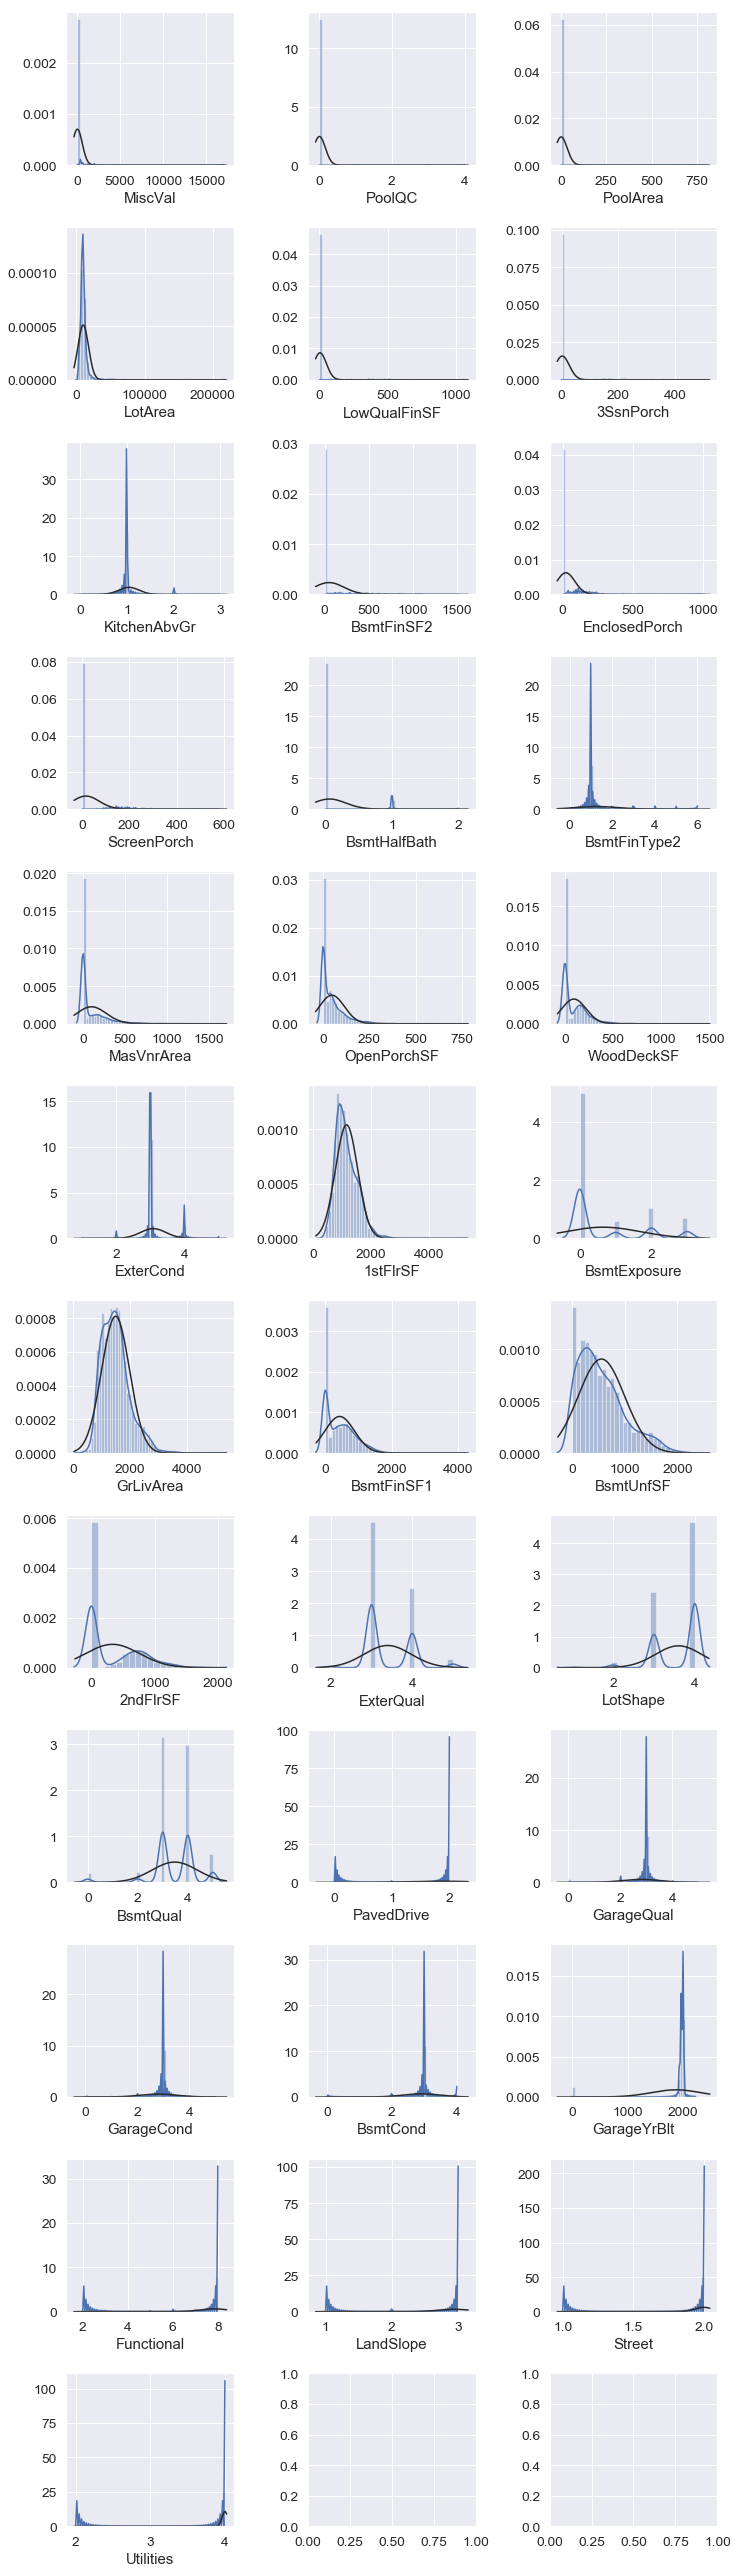

In [37]:
high_skewed_features = skewness.loc[abs(skewness.Skew) >= 0.75].index.values
plot_df_distributions(concated_dataset, columns=high_skewed_features)

# Fixing skewness with Boxcox transformation
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a test which works well in normal distribution. Such as Neural netork regressors.

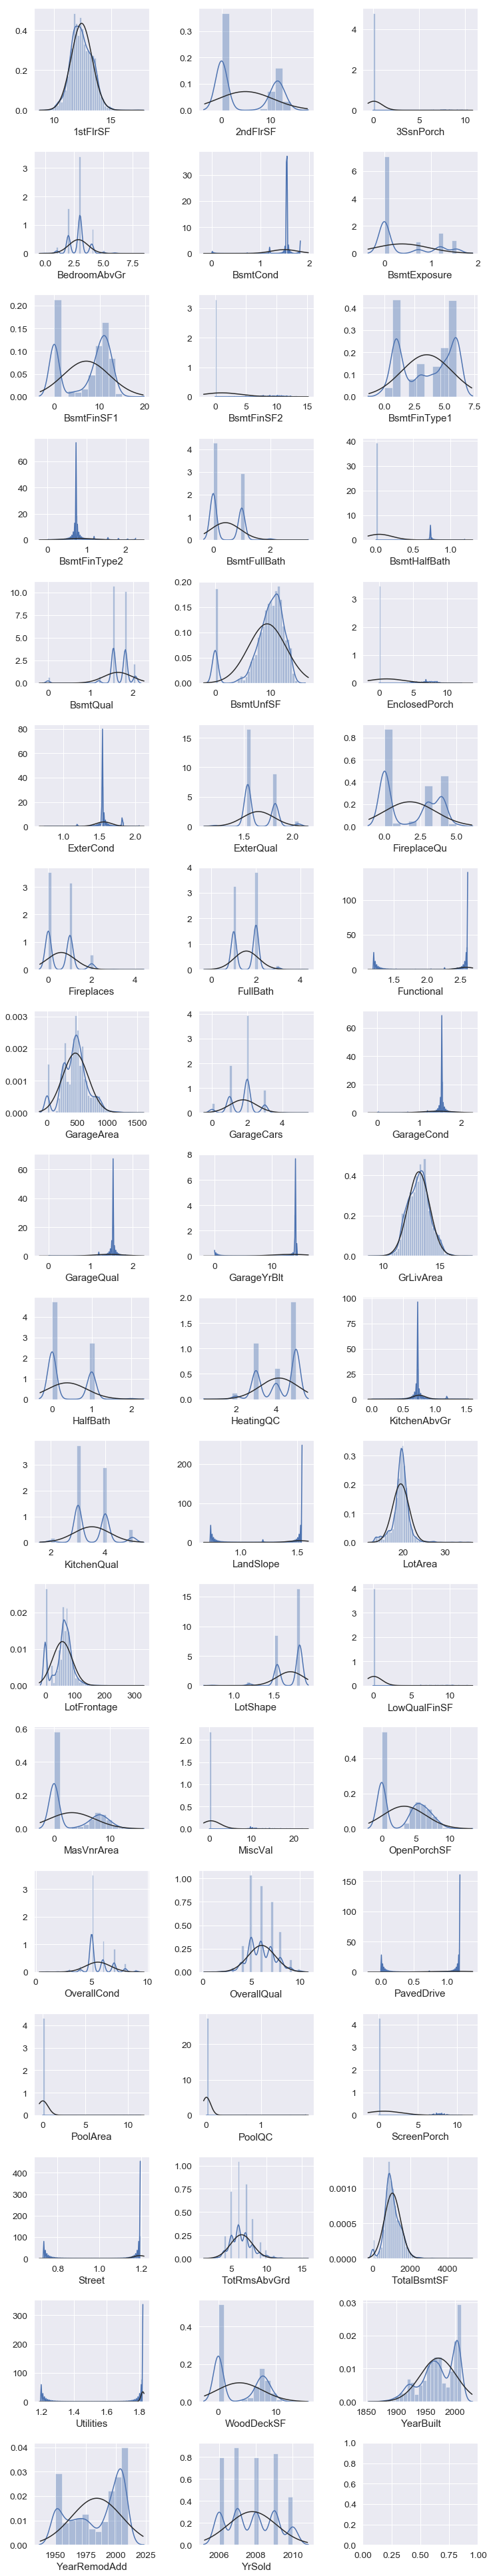

In [38]:
from scipy.special import boxcox1p

lam = 0.15
for feat in high_skewed_features:
    concated_dataset[feat] = boxcox1p(concated_dataset[feat], lam)
    
plot_df_distributions(concated_dataset, columns=Numerical_feature)

Either or both of teh scaller is used. Keeping both so that I can experiment later.

# Standard Scaling
The StandardScaler assumes your data is normally distributed within each feature and will scale them such that the distribution is now centred around 0, with a standard deviation of 1.

The mean and standard deviation are calculated for the feature and then the feature is scaled based on:
$\frac{x_i-mean(x)}{stdv(x)}$

In [39]:
from sklearn.preprocessing import StandardScaler
Std_nummerical = StandardScaler()
Std_nummerical.fit(concated_dataset[Numerical_feature])
concated_dataset[Numerical_feature] = Std_nummerical.transform(concated_dataset[Numerical_feature])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


# Minmax Scaling
Minmax normalization is a normalization strategy which linearly transforms x to y= (x-min)/(max-min), where min and max are the minimum and maximum values in X, where X is the set of observed values of x. 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


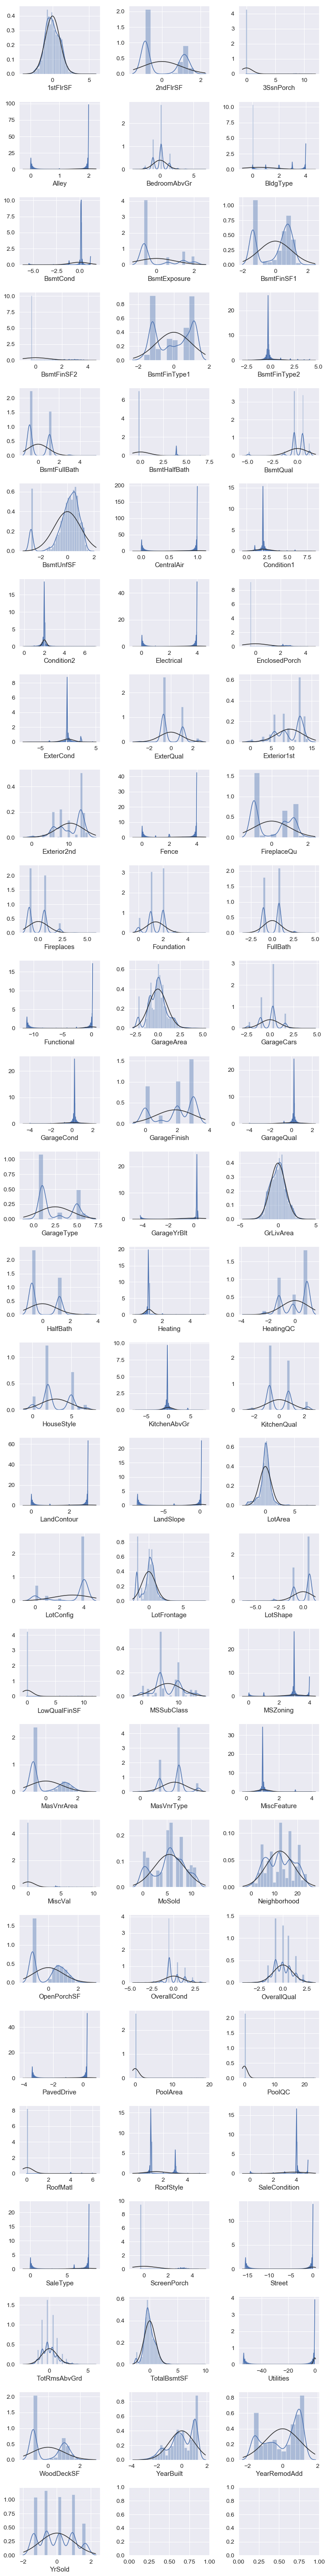

In [40]:
plot_df_distributions(concated_dataset)


# Dimentionality Reduction

# Principle Component Analysis

In [108]:
from sklearn.decomposition import PCA
pca=PCA(n_components=0.90)
concated_dataset_reduced=pca.fit_transform(concated_dataset)


In [109]:
print(pca.explained_variance_ratio_)

[0.23092995 0.1411509  0.10221792 0.07106342 0.06242631 0.02723364
 0.02378337 0.01997851 0.01663343 0.01640036 0.01589307 0.01322196
 0.01221636 0.01119477 0.01058346 0.01008776 0.00983799 0.00946059
 0.00822674 0.00784166 0.00756848 0.00733166 0.00703849 0.00681802
 0.00674127 0.00654478 0.00637423 0.00620829 0.00616669 0.00599864
 0.00589557 0.00576035 0.00546789]


# Preparing for One Hot encoding
In order to make unordered catagories represented in one hot encoding with pandas dummies we have to make the feature object type first. This one is for flexiblity optional usage.

# Removing Black listed features
This is experimental if it this does not help the model. We will undo that.

In [110]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.785965,1.217185,-0.112391,2,0.170991,0,0.167605,-0.653371,0.803260,-0.358297,...,8,-0.308434,0.064294,0.995259,-0.448619,0.018525,-0.932842,1.047630,0.897853,0.157001
1,0.411572,-0.858991,-0.112391,2,0.170991,0,0.167605,2.031070,0.977559,-0.358297,...,8,-0.308434,0.064294,-0.285332,0.499890,0.018525,1.334635,0.156123,-0.394399,-0.603230
2,-0.568798,1.224009,-0.112391,2,0.170991,0,0.167605,0.619135,0.613830,-0.358297,...,8,-0.308434,0.064294,-0.285332,-0.299101,0.018525,-0.932842,0.981592,0.849992,0.157001
3,-0.436326,1.158185,-0.112391,2,0.170991,0,1.198675,-0.653371,0.237682,-0.358297,...,8,-0.308434,0.064294,0.354963,-0.682242,0.018525,-0.932842,-1.858022,-0.681566,-1.363461
4,0.104810,1.321148,-0.112391,2,1.386699,0,0.167605,1.427195,0.764358,-0.358297,...,8,-0.308434,0.064294,1.635554,0.226551,0.018525,1.083904,0.948573,0.754269,0.157001


# One hot encoding
by Pandas dummy variable

# Splitting Data back to Train and Test set

In [134]:
#Spliting code while using PCA
train_postprocess=concated_dataset_reduced[0:1456]
print("train shape",train_postprocess.shape)
test_postprocess = concated_dataset_reduced[1456:2915]
print("test shape",test_postprocess.shape)

train shape (1456, 33)
test shape (1459, 33)


# Removing Out layers
We will use simple isolation Forest to remove outlayers.In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using  random partitioning like in isolation tree or any decession tree, they should be identified closer to the root of the tree (shorter average path length) with fewer splits necessary.

# 0. Processing data for feeding NN
Usually float32 formated data is feed to neural network so that it can calculate small numbers without any round off or truncation error.  

In [155]:
#PCA 
x_train = train_postprocess.astype(np.float32)
x_train

array([[-7.290033  , -4.216805  ,  1.4721972 , ...,  0.23119834,
         0.06813312, -0.64299566],
       [11.7095375 ,  2.4171116 , -1.2325543 , ...,  1.065158  ,
         0.9710645 , -0.9018031 ],
       [-7.271841  , -4.4367523 ,  1.6527947 , ...,  0.41924506,
        -0.23619662, -0.3602034 ],
       ...,
       [-5.5290737 ,  5.400993  ,  5.251342  , ..., -0.3583004 ,
        -1.5017983 ,  0.27646905],
       [-0.3038616 ,  3.926655  , -2.162755  , ..., -0.24616694,
         0.46045148,  0.46778762],
       [-4.7870154 ,  6.3237767 , -1.5674143 , ...,  0.3471591 ,
         0.44913203,  0.96713144]], dtype=float32)

In [156]:
#PCA
y_train = train["SalePrice"].values.astype(np.float32)


In [158]:
Test=np.expm1(y_train)
print(Test)

[inf inf inf ... inf inf inf]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


In [159]:
#PCA
x_test = test_postprocess.astype(np.float32)
x_test.shape

(1459, 33)

# 1.1 Splitting Training set to valid-train set 
To understand how our model is doing we must have some validation set. We will check performance on every 100 epoch on validation set. We have also implemented early stoping.Uff!! We took 25% validation set.

In [160]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(x_train, y_train, test_size=0.1, random_state=200)

1.2 keeping some important shapes in variables for ease of use

In [6]:
m_train,n_train=X_train_val.shape
m_val,n_val=X_test_val.shape
m_test,n_test=x_test.shape

NameError: name 'X_train_val' is not defined

# Importing Libraries 
We imported data time to save check points

In [2]:
import tensorflow as tf
from datetime import datetime


# Final Model

We added the bias to the input 

In [3]:
#scalling and adding bias

scaled_x_train_plus_bias = np.c_[np.ones((m_train, 1)),X_train_val]
scaled_x_val_plus_bias = np.c_[np.ones((m_val, 1)),X_test_val]
scaled_x_test_plus_bias = np.c_[np.ones((m_test, 1)),x_test]


NameError: name 'np' is not defined

In [ ]:
# hidden layers neuron numbers, batchsize and epoch number
tf.reset_default_graph()

n_inputs = n_train
n_hidden1 = 32
n_hidden2 = 16
n_hidden3=8
n_hidden4=4
n_hidden5=8
n_hidden6=4
n_outputs = 1
n_epochs = 5000 
batch_size = 100

 # Learning rate scheduling (Exponential scheduling) 
Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge . If we set it too low, training will eventually converge to the optimum, but it will take a very long time. If we set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle). We may be able to find a fairly good learning rate by training your network several times during just a few epochs using various learning rates and comparing the learning curves. The ideal learning rate will learn quickly and converge to good solution. However, We can do better than a constant learning rate: if we start with a high learning rate and then reduce it once it stops making fast progress, we can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules. we have used exponantial learning scheduling.<br />
Exponential scheduling:<br />
Set the learning rate to a function of the iteration number t: $η(t) = η_0* 10^{(–t/r)}$. This works great, but it requires tuning $η_0$ and r. The learning rate will drop by a factor of 10 every r steps. 

In [ ]:
#Learning rate with schedular
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

In [5]:
#Place holder initiallizations
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32,shape=(None), name="y")

NameError: name 'n_inputs' is not defined

# Dropout
The most popular regularization technique for deep neural networks is arguably dropout. It was proposed by G. E. Hinton in 2012 and further detailed in a paper21 by Nitish Srivastava et al., and it has proven to be highly successful: even the state-ofthe-art neural networks got a 1–2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%). It is a fairly simple algorithm: at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step . The hyperparameter p is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.


In [4]:
#Drop out initializations ,tunable per layer wise 
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate_X = 0.1
dropout_rate_1=0.2
dropout_rate_2=0.2
dropout_rate_3=0.2
dropout_rate_4=0.0
dropout_rate_5=0.4
dropout_rate_6=0.0
X_drop = tf.layers.dropout(X, dropout_rate_X, training=training)
he_init = tf.variance_scaling_initializer()

NameError: name 'X' is not defined

# Max norm regularization
consists in clipping each neuron's weight vector after each training step to ensure that its norm never exceeds some threshold. <br />
for each neuron, it constrains the weights w of the incoming connections such that $∥ w ∥_2 \leqq r$, where r is the max-norm hyperparameter and $∥ · ∥_2$ is the $ℓ_2$ norm. We typically implement this constraint by computing $∥w∥_2$ after each training step and clipping w if needed $(w\leftarrow \frac{r}{||w||_2}   )$. Reducing r increases the amount of regularization and helps reduce overfitting. Maxnorm regularization can also help alleviate the vanishing/exploding gradients problems. 






Reference:1 chap:11

In [168]:
#max norn fuctions

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

#Threshold tuning option
max_norm_reg = max_norm_regularizer(threshold=1.0)


I created a custom layer for reducing repetation of same code like calling kernal_regularizer and initializer.

# He initialization 
In order to overcome exploding gradient and vinishing gradient problem,We need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction (please check out the paper if you are interested in the mathematical details). It is actually not possible to guarantee both unless the layer has an equal number of input and output connections, but they proposed a good compromise that has proven to work very well in practice: the connection weights must be initialized randomly as described in Equation 11-1, where ninputs and noutputs are the number of input and output connections for the layer whose weights are being initialized (also called fan-in and fan-out). This initialization strategy is often called Xavier initialization (after the author’s first name), or sometimes Glorot initialization.Ref:1
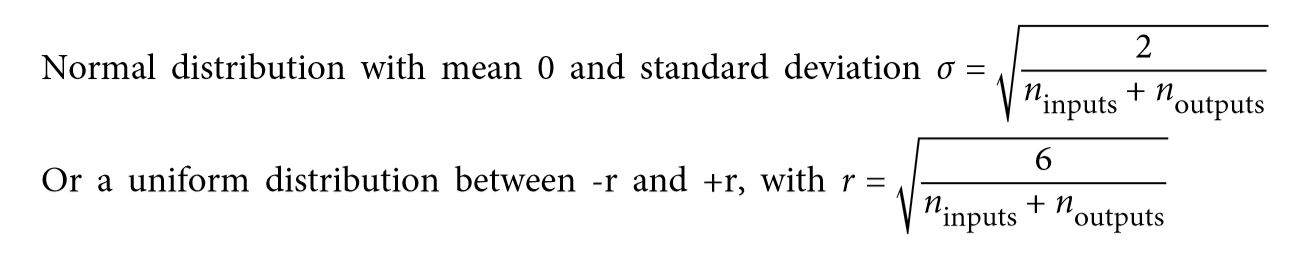

# Batch Normalization
In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) to address the vanishing/exploding gradients problems, and more generally the problem that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change (which they call the Internal Covariate Shift problem). The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model learn the optimal scale and mean of the inputs for each layer. In order to zero-center and normalize the inputs, the algorithm needs to estimate the inputs’ mean and standard deviation. It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized in Equation 11-3. <br /> 
• μB is the empirical mean, evaluated over the whole mini-batch B.  <br /> 
• σB is the empirical standard deviation, also evaluated over the whole mini-batch.  <br /> 
• mB is the number of instances in the mini-batch. <br /> 
• x(i) is the zero-centered and normalized input.
• γ is the scaling parameter for the layer.<br /> 
• β is the shifting parameter (offset) for the layer.<br />
• ϵ is a tiny number to avoid division by zero (typically 10–3
This is called a smoothing term.<br />
• z(i) is the output of the BN operation: it is a scaled and shifted version of the inputs.Ref:1 chapter 11
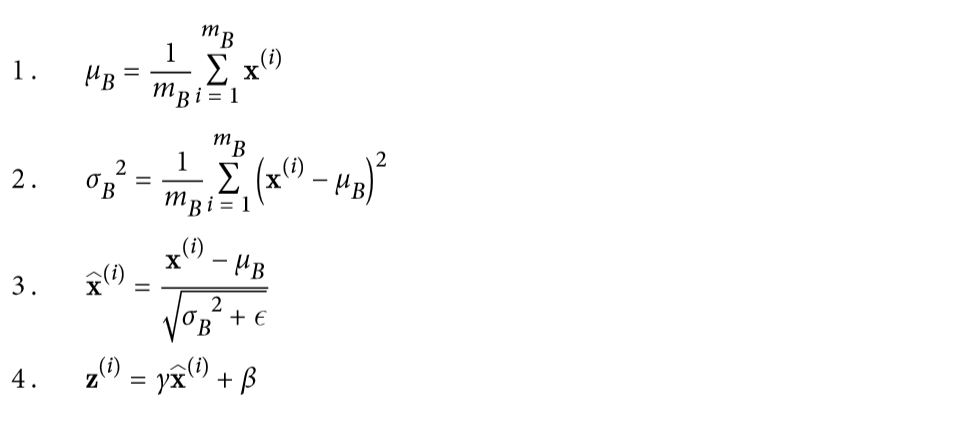

In [169]:
#Batch normalizaion function and He initializer
from functools import partial
batch_norm_momentum=0.9

he_init = tf.variance_scaling_initializer()

Custom_batch_normalized_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

Custum_dense_layer = partial(
            tf.layers.dense,kernel_initializer=he_init, use_bias=True, bias_initializer=tf.zeros_initializer(),
kernel_regularizer=max_norm_reg)

#  Activation Function (ELU)
“Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs),” D. Clevert, T. Unterthiner, S. Hochreiter (2015).
paper by Djork-Arné Clevert et al. proposed a new activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants in their experiments: training time was reduced and the neural network performed better on the test set. It is represented in Figure, and Equation  shows its definition.
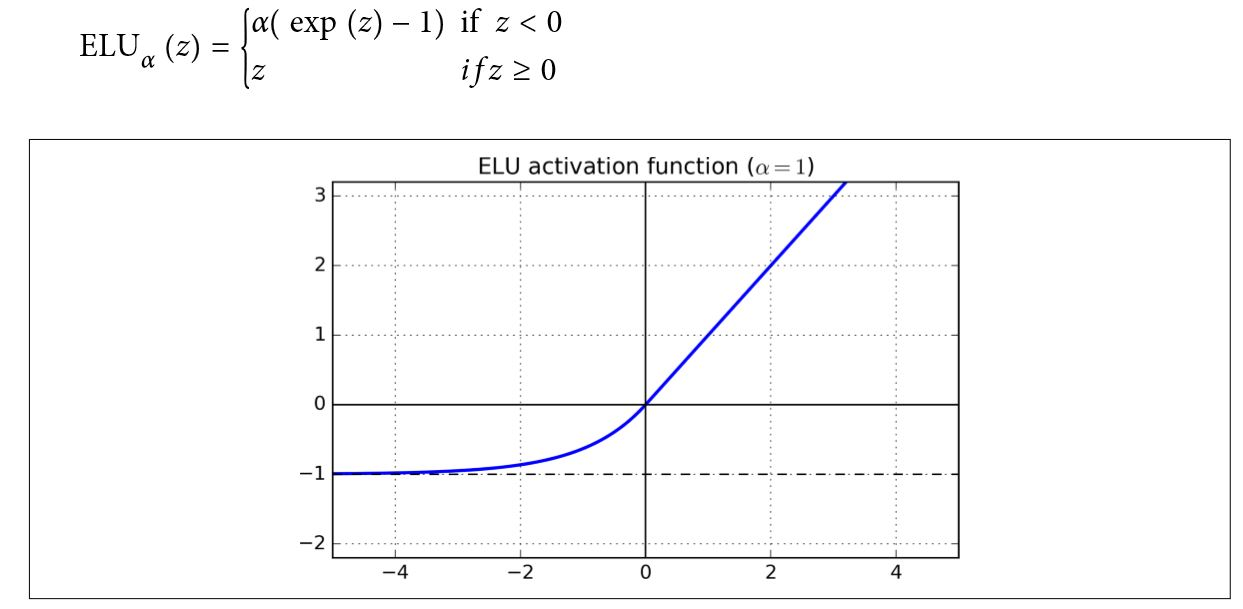

In [170]:


with tf.name_scope("dnn"):
    
    #layer1   
    hidden1 =Custum_dense_layer(X, n_hidden1,name="hidden1")
    bn1 = Custom_batch_normalized_layer(hidden1)
    hidden1_bn = tf.nn.elu(bn1)
    hidden1_drop = tf.layers.dropout(hidden1_bn, dropout_rate_1, training=training)

    #layer2   
    hidden2 =Custum_dense_layer(hidden1_drop, n_hidden2,name="hidden2")
    bn2 = Custom_batch_normalized_layer(hidden2)
    hidden2_bn = tf.nn.elu(bn2)
    hidden2_drop = tf.layers.dropout(hidden2_bn, dropout_rate_2, training=training)
    
    #layer3   
    hidden3 =Custum_dense_layer(hidden2_drop, n_hidden3,name="hidden3")
    bn3 = Custom_batch_normalized_layer(hidden3)
    hidden3_bn = tf.nn.elu(bn3)
    hidden3_drop = tf.layers.dropout(hidden3_bn, dropout_rate_3, training=training)
    
    #layer4
    hidden4 =Custum_dense_layer(hidden3_drop, n_hidden4,name="hidden4")
    bn4 = Custom_batch_normalized_layer(hidden4)
    hidden4_bn = tf.nn.elu(bn4)
    hidden4_drop = tf.layers.dropout(hidden4_bn, dropout_rate_4, training=training)
    
    #output
    y_pred_before_BN = Custum_dense_layer(hidden4_drop,n_outputs,name="outputs")
    y_pred=Custom_batch_normalized_layer( y_pred_before_BN)







In [171]:
#Loss calculation and optimizer
error=y_pred-y
mse = tf.reduce_mean(tf.square(error),name="mse")




with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(mse,global_step=global_step)

init = tf.global_variables_initializer()

In [172]:
#batch making and shuffling
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Gradient Clipping
A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold . This is called Gradient Clipping. In general people now prefer Batch Normalization, but it’s still useful. 

In [173]:
#Clipping gradient and saver object
saver = tf.train.Saver()
clip_all_weights=tf.get_collection("max_norm")

# Early Stopping
To avoid overfitting the training set, a great solution is early stopping: just interrupt training when its performance on the validation set starts dropping. One way to implement this with TensorFlow is to evaluate the model on a validation set at regular intervals (e.g., every 50 steps), and save a “winner” snapshot if it outperforms previous “winner” snapshots. Count the number of steps since the last “winner” snapshot was saved, and interrupt training when this number reaches some limit (e.g., 2,000 steps). Then restore the last “winner” snapshot.

In [174]:
#Session with Early stopping mechanism

max_checks_without_progress = 1500
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_val, y_train_val, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            #sess.run(clip_all_weights)

        loss_val = mse.eval(feed_dict={X: X_test_val, y: y_test_val})
        
        
        #Check whether to stop or not
        if loss_val < best_loss:
            save_path = saver.save(sess,"./Final_Certairi.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        #printing at run time
        if epoch %100==0:
            acc_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mse.eval(feed_dict={X: X_test_val, y: y_test_val})
            
            
            
            print("Epoch_number",epoch, "Batch error:", acc_batch, "Val error:", acc_val)
    pred=y_pred.eval(feed_dict={X: x_test})

                
with tf.Session() as sess:
    saver.restore(sess, "./Final_Certairi.ckpt")


Epoch_number 0 Batch error: 34564755000.0 Val error: 37098690000.0
Epoch_number 100 Batch error: 7627703000.0 Val error: 5213851000.0
Epoch_number 200 Batch error: 5845434000.0 Val error: 5285844000.0
Epoch_number 300 Batch error: 2941820700.0 Val error: 5052503000.0
Epoch_number 400 Batch error: 6316232700.0 Val error: 5004518400.0
Epoch_number 500 Batch error: 5230781400.0 Val error: 5003147000.0
Epoch_number 600 Batch error: 5886053400.0 Val error: 4935707000.0
Epoch_number 700 Batch error: 4594462700.0 Val error: 4953630000.0
Epoch_number 800 Batch error: 8156523000.0 Val error: 4957187000.0
Epoch_number 900 Batch error: 6496071000.0 Val error: 4945933000.0
Epoch_number 1000 Batch error: 5118075400.0 Val error: 4935927000.0
Epoch_number 1100 Batch error: 5486468600.0 Val error: 4935129600.0
Epoch_number 1200 Batch error: 6749470000.0 Val error: 4936683000.0
Epoch_number 1300 Batch error: 6945498600.0 Val error: 4935655400.0
Epoch_number 1400 Batch error: 4352979000.0 Val error: 493

In [ ]:
pred_non_expo=np.expm1(pred)


In [175]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = pred

sub.to_csv('Final With Early stopping.csv',index=False)

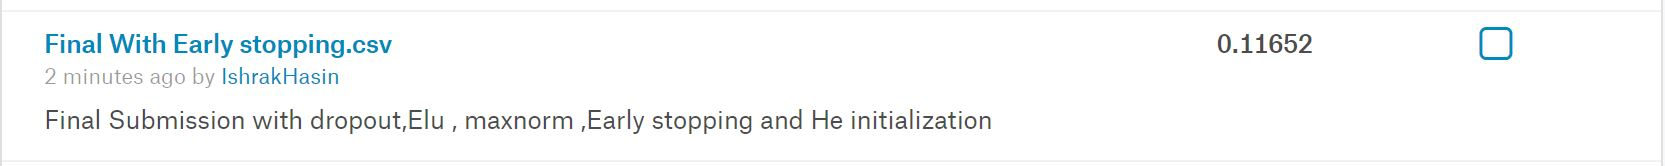

# Simple DNN for Prototyping

In [70]:
learning_rate = 0.1 
num_steps =7500
beta = .005
hidden_1 = 16 
hidden_2 = 8
hidden_3 = 4 
input_dim = x_train.shape[1]
output_dim = 1  
X_tf = tf.placeholder("float" ) 
y_tf = tf.placeholder("float" ) 

In [71]:
weights = {'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),  
           'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),  
           'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])), 
           'out': tf.Variable(tf.random_normal([hidden_3, output_dim ])) }

biases = {'b1': tf.Variable(tf.random_normal([hidden_1])),
          'b2': tf.Variable(tf.random_normal([hidden_2])),
          'b3': tf.Variable(tf.random_normal([hidden_3])),
          'out': tf.Variable(tf.random_normal([output_dim])) } 

In [72]:
 def ann_model(X_val): 
        layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ]) 
        layer_1 = tf.nn.relu(layer_1) 
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2) 
        layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']) 
        layer_3 = tf.nn.relu(layer_3)
        layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases ['out']) 
        return layer_out 

In [73]:
# Model Construct 
model = ann_model(X_tf) 
# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(y_tf - model)) 
regularizer_1 = tf.nn.l2_loss(weights['w1']) 
regularizer_2 = tf.nn.l2_loss(weights['w2']) 
regularizer_3 = tf.nn.l2_loss(weights['w3']) 
cost = tf.reduce_mean(cost + beta*regularizer_1 + beta*regularizer_2 
                      + regularizer_3)

In [74]:
# Adam optimizer will update weights and biases after each step 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) .minimize(cost)

In [75]:
# Initialize variables 
init = tf.global_variables_initializer() 

In [76]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver() 

In [77]:
 with tf.Session() as sess: 
        sess.run(init) 
        for i in range(num_steps): 
            sess.run(optimizer, feed_dict={X_tf:x_train, y_tf:y_train})  
            if (i+1)%100 == 0: 
                 print("batch no : ",i+1) 
        save_path = saver.save(sess, "/tmp/model.ckpt") 
        print("Model saved in path: %s" % save_path) 
        pred = sess.run(model, feed_dict={X_tf: x_test}) 


batch no :  100
batch no :  200
batch no :  300
batch no :  400
batch no :  500
batch no :  600
batch no :  700
batch no :  800
batch no :  900
batch no :  1000
batch no :  1100
batch no :  1200
batch no :  1300
batch no :  1400
batch no :  1500
batch no :  1600
batch no :  1700
batch no :  1800
batch no :  1900
batch no :  2000
batch no :  2100
batch no :  2200
batch no :  2300
batch no :  2400
batch no :  2500
batch no :  2600
batch no :  2700
batch no :  2800
batch no :  2900
batch no :  3000
batch no :  3100
batch no :  3200
batch no :  3300
batch no :  3400
batch no :  3500
batch no :  3600
batch no :  3700
batch no :  3800
batch no :  3900
batch no :  4000
batch no :  4100
batch no :  4200
batch no :  4300
batch no :  4400
batch no :  4500
batch no :  4600
batch no :  4700
batch no :  4800
batch no :  4900
batch no :  5000
batch no :  5100
batch no :  5200
batch no :  5300
batch no :  5400
batch no :  5500
batch no :  5600
batch no :  5700
batch no :  5800
batch no :  5900
batch 

In [80]:
prediction = np.expm1(pred) 


In [81]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('Super',index=False)

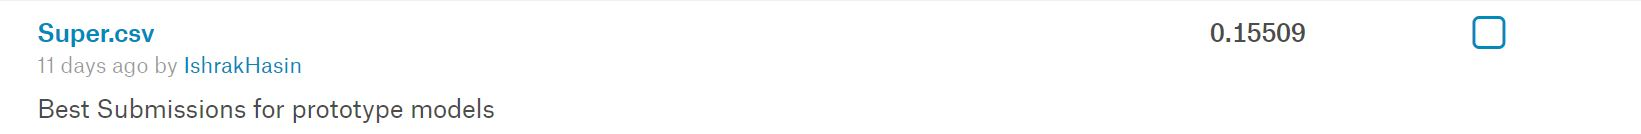

Note: The Final model is the model above the current model. The last model is the simplified model for quick prototyping. 

# Discussion


This above(Final Nodel) mentioned model is highly flexible and can be tune according to necessary.We can have a exhustive search on top of that.For both of the models I used Max norm normalization and dropout as regularizer.Kernel is regularized with batch normalization and initialized by he initialization.Dropout rates can be tuned per layer.As activation fuction I used elu instead of relu. This model checks for improvement in validation set for 2000 step if no improvement is found the model stops the training.Since the model is so flexible the next step can be to search over the entire parameter spaces using oscar,randomsearchCV or Grid Search.Lastly, This is pretty strong model and made without any prior on data preprocessing so better result can be achived with strong data preprocessing knowledge.

# Reference

Any suggestion is greatly welcomed.<br />
Mail Id for comment:hasinishrak12@gmail.com

# Grid search

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)